# Modele generatywne; Generative Adversarial Networks 

[link](https://arxiv.org/pdf/1701.00160.pdf)

Kolejną kategorią modeli generatywnych, którą się zajmiemy są modele <i>Generative Adversarial Networks</i>. Ale zanim przejdziemy do opisu ich działania zacznijmy od omówienia tego czym różnią się od bardziej tradycyjnego podejścia do generowania danych za pomocą sieci neuronowych.
        
W klasycznym ujęciu tego problemu zagadnienie generowania danych możemy sprowadzić do problemu aproksymacji estymatora największej wiarygodności (<i>Maximum Likelihood Estimation</i>, MLE) bazując na zmiennych ukrytych $z$:

$$\theta^* = \underset{\theta}{\operatorname{argmax}} \sum_{i=1}^n \log p_{model}(x_i|z;\theta)$$

Zazwyczaj uczymy taki model poprzez maksymalizację podobieństwa pomiędzy rzeczywistym rozkładem prawdopodobieństwa a tym indukowanym przez model:

$$q_{\phi}^* = \underset{\phi}{\operatorname{argmin}}d_{KL}(p(x)||p_{model}(x|z))$$

Takie podejście ma pewne wady, przede wszystkim wymaga przyjęcia pewnych założeń dotyczących modelu. Mogą one być niepoprawne i utrudnić uzyskanie dobrego wyniku czy też znacznie spowolnić proces uczenia takiej sieci.


Sieci GAN są modelem, który umożliwia pominięcie założeń dotyczących uczonego rozkładu prawdopodobieństwa. Idea takiego modelu jest prosta, sieć się uczy nie wprost. Zamiast porównywać otrzymane wyniki z przyjętym rozkładem prawdopodobieństwa budujemy de facto dwa modele: <b>Generator</b>, który generuje obserwacje na podstawie wektora zmiennych ukrytych $\tilde{x} = G(Z;\theta)$ i <b>Dyskryminator</b> $D(x,\tilde{x};\psi)$, który uczy się odróżniać rzeczywiste obserwacje $x$ od tych generowanych przez generator $\tilde{x}$.

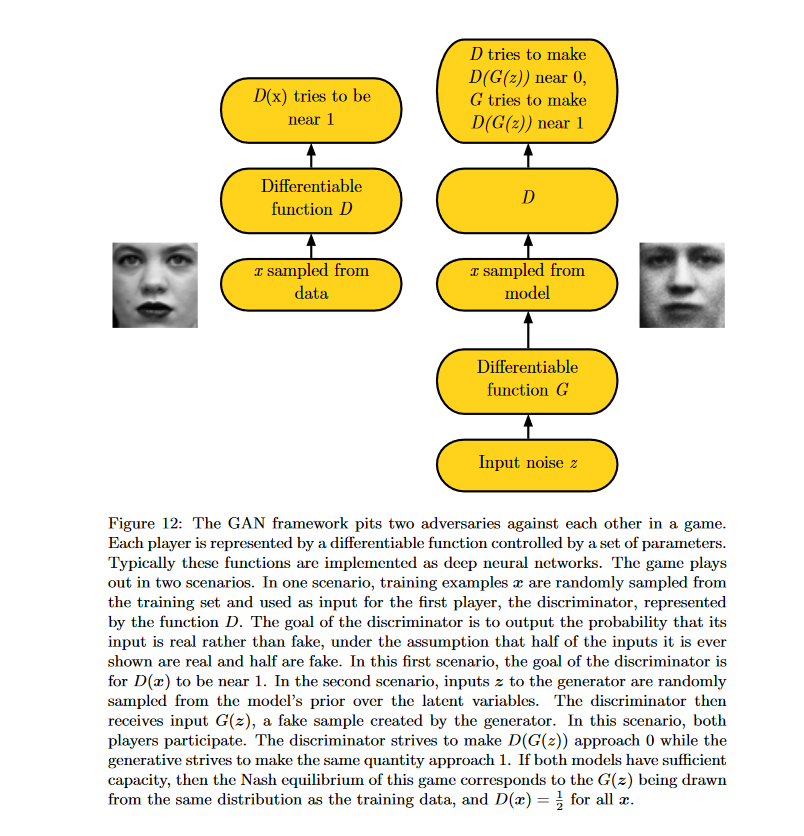

Sieci GAN mają szereg zalet w stosunku to innych modeli generatywnych:

- Obrazy generowane przez takie modele charakteryzują się znacznie wyższą jakością niż w przypadku innych rodzin modeli generatywnych.
- Modele GAN wymagają znacznie mniejszej liczby założeń niż inne rodziny; nie musimy definiować rozkładu prawdopodobieństwa z którego generowane będą nowe obserwacje, ani wykorzystywać łańcuchów Markowa.
- Przez to też są w stanie uczyć się efektywnie znacznie trudniejszych rozkładów bez wprowadzania z góry obciążenia.
- Są one de facto modelami częściowo nadzorowanymi - dyskryminator uczy się klasyfikować obserwacje.

Tak zmodyfikowane podejście do procesu uczenia wymaga też innego sposobu liczenia funkcji straty.

W przypadku dyskryminatora funkcja kosztu to po prostu entropia pomiędzy danymi rzeczywistymi a tymi wygenerowanymi przez generator:

$$ J_D(\theta,\psi) =- E_{x \sim p_{data}}\log D(x) -E_z \log (1 - D(G(z)) $$

W przypadku generatora sytuacja jest mniej trywialna. Modele GAN możemy (i powinniśmy) analizować za pomocą narzędzi teorii gier. Celem dyskryminatora jest nauczenie się idealnie odróżniać rzeczywiste obiekty od tych generowanych przez generator. Generator natomiast chce nauczyć się możliwie jak najlepiej oszukiwać dyskryminator. Jego funkcję kosztu możemy przedstawić jako:

$$J_G(\theta,\psi) = - J_D(\theta, \psi)$$

W takim wypadku otrzymujemy model, który możemy traktować jako dwuosobową <b>grę o sumie stałej</b>. W takim wypadku każdy z graczy wygrywa gdy maksymalizuje swoją użyteczność $U(\theta,\psi) = - J_D(\theta, \psi)$.

Celem uczenia takiego modelu jest znalezienie <b>równowagi Nasha</b> dla takiej gry. Możemy to zrobić efektywnie korzystając z twierdzenia o minimaksie J. von Neumanna:

$$\theta^* = \underset{\theta}{\operatorname{argmin}} \underset{\psi}{\operatorname{max}}U(\theta,\psi)$$

Z punktu widzenia teorii prawdopodobieństwa, równowaga tej gry jest tożsama z minimalizacją dywergencji Jensena-Shannona.

Jednak wprowadza to problem innej natury - znalezienie równowagi Nasha w takiej grze jest jeszcze trudniejszym zadaniem niż optymalizacja funkcji straty (równowaga jest punktem siodłowym!). W szczególności:
- Naszym celem jest minimalizacja entropii dyskryminatora i maksymalizacja entropii generatora. Gdy pierwszy z tych celi osiągniemy za szybko, generator nie jest w stanie uczyć się dalej.
-  Fakt, że musimy skoordynować zmiany funkcji kosztu dla dwóch graczy, powoduje, że rozwiązanie nie tyle zbiega do rozwiązania optymalnego, co oscyluje wokół niego; spadek wartości funkcji straty dla jednego gracza zazwyczaj oznaca wzrost funkcji straty dla drugiego gracza. 
- Model ma tendencję do mapowania różnych danych do tego samego neuronu na kolejnej warstwie; powoduje to, że generowane wyniki charakteryzują się małą zmiennością.

Te problemy częściowo można obejść poprzez modyfikację funkcji kosztu generatora:

- zamiast minimalizować prawdopodobieństwo, że dyskryminator ma rację, można maksymalizować prawdopodobieństwo, że dyskryminator się myli.
- inną potencjalną modyfikacją jest implementacja funkcji kosztu generatora w sposób taki, żeby była ona estymatorem największej wiarygodności.

Inną widoczną wadą modeli GAN jest brak interpretowalności ich wyników oraz wyraźnie trudniejsza ocena jakości dopasowania.

Przejdźmy do eksperymentu:

In [1]:
using Flux, MLDatasets.MNIST
using Flux: mse, throttle, params, Statistics, @epochs
using Base.Iterators: partition
using Printf, BSON, LinearAlgebra
using Zygote
using Images

In [2]:
batch_size = 128
latent_dim = 100

100

In [3]:
train_imgs, train_labels = MNIST.traindata(Float32);

In [4]:
Y = Float32.(Flux.onehotbatch(train_labels, 0:9));

In [5]:
imgs = reshape(@.(2f0 * train_imgs - 1f0), 28, 28, 1, :);

In [6]:
data = [(imgs[:,:,:,i], Y[:,i]) for i in partition(1:size(imgs,4), batch_size)];

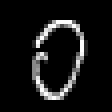

In [7]:
Gray.(dropdims(@.(data[3][1][:,:,:,5]+1.f0) / 2.f0; dims = 3))

In [8]:
d_labels = Chain(Dense(10,28^2), x-> reshape(x, 28, 28, 1, size(x, 2))) 
d_common = Chain(Conv((3,3), 2=>128, pad=(1,1), stride=(2,2)),
                  x-> leakyrelu.(x, 0.2f0),
                  Dropout(0.4),
                  Conv((3,3), 128=>128, pad=(1,1), stride=(2,2), leakyrelu),
                  x-> leakyrelu.(x, 0.2f0),
                  x-> reshape(x, :, size(x, 4)),
                  Dropout(0.4),
                  Dense(6272, 1))

Chain(Conv((3, 3), 2=>128), #5, Dropout(0.4), Conv((3, 3), 128=>128, leakyrelu), #6, #7, Dropout(0.4), Dense(6272, 1))

In [9]:
function discriminator(label, data)
    x = cat(d_labels(label), data, dims=3)
    return d_common(x)
end

discriminator (generic function with 1 method)

In [10]:
g_labels = Chain(Dense(10, 49), x-> reshape(x, 7 , 7 , 1 , size(x, 2)))
g_latent = Chain(Dense(latent_dim, 6272), x-> leakyrelu.(x, 0.2f0), x-> reshape(x, 7, 7, 128, size(x, 2))) 
g_common = Chain(ConvTranspose((4, 4), 129=>128; stride=2, pad=1),
            BatchNorm(128, leakyrelu),
            Dropout(0.25),
            ConvTranspose((4, 4), 128=>64; stride=2, pad=1),
            BatchNorm(64, leakyrelu),
            Conv((7, 7), 64=>1, tanh; stride=1, pad=3)) 

Chain(ConvTranspose((4, 4), 129=>128), BatchNorm(128, leakyrelu), Dropout(0.25), ConvTranspose((4, 4), 128=>64), BatchNorm(64, leakyrelu), Conv((7, 7), 64=>1, tanh))

In [11]:
function generator(labels, noise)
    x = cat(g_labels(labels), g_latent(noise), dims=3)
    return g_common(x)
end

generator (generic function with 1 method)

In [12]:
function discriminator_loss(real_output, fake_output)
    real_loss = Flux.Losses.logitbinarycrossentropy(real_output, 1f0)
    fake_loss = Flux.Losses.logitbinarycrossentropy(fake_output, 0f0)
    return (real_loss + fake_loss)
end

generator_loss(fake_output) = Flux.Losses.logitbinarycrossentropy(fake_output, 1f0)

generator_loss (generic function with 1 method)

In [13]:
function sample(noise, labels)
    @eval Flux.istraining() = false
    imgs = @.(generator(labels, noise))
    @eval Flux.istraining() = true
    Gray.((transpose(dropdims(reduce(vcat, reduce.(hcat, partition(imgs, 4))); dims=(3, 4)))
            .+ 1f0)./2.f0)
end

sample (generic function with 1 method)

In [14]:
opt_dscr = ADAM(0.0002, (0.5, 0.99))
opt_gen = ADAM(0.0002, (0.5, 0.99))

ADAM(0.0002, (0.5, 0.99), IdDict{Any,Any}())

In [15]:
function train_discriminator(fake_data, fake_labels, original_data, labels, opt_discr)
    ps = params(d_labels, d_common)
    loss, back = Zygote.pullback(ps) do
        discriminator_loss(discriminator(labels, original_data), discriminator(fake_labels, fake_data))
    end
    grads = back(1f0)
    Flux.Optimise.update!(opt_discr, ps, grads)
    return loss
end

Zygote.@nograd train_discriminator

4×4 Array{Int64,2}:
 9  8  4  0
 0  6  7  7
 4  9  1  0
 3  5  6  2

┌ Info: Beginning training loop...
└ @ Main In[16]:3
┌ Info: Epoch 1
└ @ Main In[16]:6


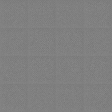

4×4 Array{Int64,2}:
 9  8  4  0
 0  6  7  7
 4  9  1  0
 3  5  6  2

┌ Info: Epoch: 1, Discriminator loss = 1.3396611, Generator loss = 0.7167792
└ @ Main In[16]:21
┌ Info: Epoch 2
└ @ Main In[16]:6


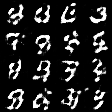

4×4 Array{Int64,2}:
 9  8  4  0
 0  6  7  7
 4  9  1  0
 3  5  6  2

┌ Info: Epoch: 2, Discriminator loss = 1.1897867, Generator loss = 0.79215074
└ @ Main In[16]:21
┌ Info: Epoch 3
└ @ Main In[16]:6


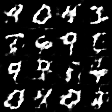

4×4 Array{Int64,2}:
 9  8  4  0
 0  6  7  7
 4  9  1  0
 3  5  6  2

┌ Info: Epoch: 3, Discriminator loss = 1.2959039, Generator loss = 0.72389
└ @ Main In[16]:21
┌ Info: Epoch 4
└ @ Main In[16]:6


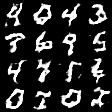

4×4 Array{Int64,2}:
 9  8  4  0
 0  6  7  7
 4  9  1  0
 3  5  6  2

┌ Info: Epoch: 4, Discriminator loss = 1.1687055, Generator loss = 0.7575877
└ @ Main In[16]:21
┌ Info: Epoch 5
└ @ Main In[16]:6


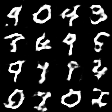

4×4 Array{Int64,2}:
 9  8  4  0
 0  6  7  7
 4  9  1  0
 3  5  6  2

┌ Info: Epoch: 5, Discriminator loss = 1.317904, Generator loss = 0.69636554
└ @ Main In[16]:21
┌ Info: Epoch 6
└ @ Main In[16]:6


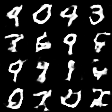

4×4 Array{Int64,2}:
 9  8  4  0
 0  6  7  7
 4  9  1  0
 3  5  6  2

┌ Info: Epoch: 6, Discriminator loss = 1.214103, Generator loss = 0.79196024
└ @ Main In[16]:21
┌ Info: Epoch 7
└ @ Main In[16]:6


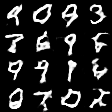

┌ Info: Epoch: 7, Discriminator loss = 1.2995602, Generator loss = 0.77526987
└ @ Main In[16]:21


4×4 Array{Int64,2}:
 9  8  4  0
 0  6  7  7
 4  9  1  0
 3  5  6  2

┌ Info: Epoch 8
└ @ Main In[16]:6


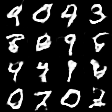

4×4 Array{Int64,2}:
 9  8  4  0
 0  6  7  7
 4  9  1  0
 3  5  6  2

┌ Info: Epoch: 8, Discriminator loss = 1.256462, Generator loss = 0.7754021
└ @ Main In[16]:21
┌ Info: Epoch 9
└ @ Main In[16]:6


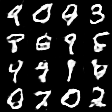

4×4 Array{Int64,2}:
 9  8  4  0
 0  6  7  7
 4  9  1  0
 3  5  6  2

┌ Info: Epoch: 9, Discriminator loss = 1.1798966, Generator loss = 0.77476954
└ @ Main In[16]:21
┌ Info: Epoch 10
└ @ Main In[16]:6


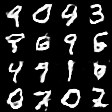

┌ Info: Epoch: 10, Discriminator loss = 1.2023497, Generator loss = 0.8124304
└ @ Main In[16]:21


In [16]:
noise = [randn(Float32,latent_dim, 1) for i=1:16]
labels = [float32.(Flux.onehotbatch(rand(0:9, 1), 0:9)) for i =1:16];
@info("Beginning training loop...")
for epoch = 1:10
    d_loss,g_loss = Inf, Inf
    @info "Epoch $epoch"
    display(reduce(vcat, reduce.(hcat, partition(Flux.onecold.(labels), 4))) .- 1)
    display(sample(noise,labels))
    for (x, labels) in data
        latents = randn(Float32,(latent_dim, batch_size))
        y = Float32.(Flux.onehotbatch(rand(0:9, batch_size), 0:9))
        ps = params(g_labels, g_latent, g_common)
        g_loss, back = Zygote.pullback(ps) do
            fake = generator(y, latents)
            d_loss = train_discriminator(fake, y, x, labels, opt_dscr)
            generator_loss(discriminator(y, fake))
        end
        grads = back(1f0)
        Flux.Optimise.update!(opt_gen, ps, grads)
    end
    @info("Epoch: $epoch, Discriminator loss = $d_loss, Generator loss = $g_loss")
    BSON.@save "CDGAN_MNIST.bson" d_labels d_common g_labels g_latent g_common
end

In [17]:
BSON.@load "CDGAN_MNIST.bson" d_labels d_common g_labels g_latent g_common

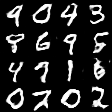

In [21]:
display(sample(noise,labels))

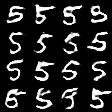

In [24]:
noise = [randn(Float32,latent_dim, 1) for i=1:16]
labels = [float32.(Flux.onehotbatch(5, 0:9)) for i =1:16];
display(sample(noise,labels))